# COGS 108 - Final Project 

# Overview

Our project sets out to analyze how the crime rates of San Diego County is affected by the "quality of education". In our analysis we determine the quality of education to be a low schools per person (less schools while having a large population in a city). We analyze this by plotting the relationship between the crime rates (calculated by number of crime / population * 100) and schools per person (calculated by number of schools / population * 100) for each city in San Diego. From our analysis we conclude that while is a correlation between education and crime rates, it is not the sole reason for high crime rates.

# Names

- Xuan Ding
- Xiuwen Ji
- Ruisen Huang
- Joanna Ma
- Ivan Flores

# Research Question

Is there a relationship between the quality of high school education and crime rates within the county of San Diego?

## Background and Prior Work

As of 2019, the US has one of the highest incarceration rates per capita in the world, having over 655 people in prisons, or in correctional facilities throughout the US. Excesive incarceration rates have historicaly been known to be a problem afflicting US society, an aspect of American life that has has been shown to disproportionally affect US citizens throughout the US. Authors such as Ava Page, and colleagues, have brought these issues to light in their literary work "Justice and Public Safety," discussing their research and findings in depths. By comparing the crime rates of educational attainment between residents of the top 10 scoring states of the US and the bottom 10 scoring states in the US, they were able to identify a correlation between the two factors they compared, that being crime rates to ecucational attainment. Moreover, studies by Lance Lochner in "Country Analysis" has shown us that educational attainment and even high level education can be an indicator of crime. Basing on low crime rates with higher educational attainment proofs and theorems to solve for crime probaility, relating to age, income levels, and educational attainment.

References (include links):  Country Analysis, International Economic Journal, 10.1080/10168737.2015.1081259, 29, 4, (527-546), (2015).
- 1) https://www.statista.com/statistics/262962/countries-with-the-most-prisoners-per-100-000-inhabitants/#:~:text=As%20the%20statistic%20above%20illustrates,Russia%20comes%20closest%20at%20381


- 2) http://www.justicepolicy.org/images/upload/07-08_rep_educationandpublicsafety_ps-ac.pdf

# Hypothesis


Crimes have a higher likelyhood of occuring in cities with a lower school per capita, within the County of San Diego. (i.e. The lower the education quality the higher the number of crime). 

Note we are considering "education quality" to be a low schools per person (less schools while having a large population in a city).

# Dataset(s)

- Dataset Name: Census_ZIP.shp
- Dataframe Name: map_city
- Link to the dataset: https://sdgis-sandag.opendata.arcgis.com/datasets/zip-code/data?geometry=-122.088%2C32.408%2C-111.634%2C34.016
- Number of observations: 123
- Year: 2018
- Description: Contains the zip code of every mailing address in the county of california and includes the city that belongs to that respective county, along with the city of that zip code and its geometric dimensions. There are 6 variables in this data set of which includes the ObjectId which is the index of the file, zip codes which is the zip code of the area, ShapeSTAre whichis the geometric square area of the region, ShapeSTLen is the length in miles of the region, geometry which is a space composed of polygons that is interpretible by the python.


- Dataset Name: ARJISPublicCrime052720.csv
- Dataframe Name: crime
- Link to the dataset: https://www.sandag.org/index.asp?classid=14&subclassid=21&projectid=446&fuseaction=projects.detail
- Number of observations: 57994
- Year: Most recent 180 days of crime as of April 27th, 2020.
- Description: crime is a collection of all the crimes within San Diego Couty within the last 180 days of commiting them.There are 6 total variables. Cm_Legend that identififys the type of crime comited, agency that identifies the location the crime was commited,Charge_Description_Orig which specifies what teh criminal was charged with. Activity Date which is the day the police report was filed, BLOCK_ADDRESS, which identifies the location the crime occured, zip code which identifies the zip area the crime was commited, and community identifies the city the crime occured in.


- Dataset Name: San Diego Zip Code.csv
- Dataframe Name: population
- Link: https://www.zip-codes.com/county/ca-san-diego.asp
- Number of Observations: 181
- Year: 2020
- Description: List of all cities of San Diego County with zip codes and their population count.


- Dataset Name: public school.csv
- Dataframe Name: school
- Link: https://www.cde.ca.gov/ds/si/ds/pubschls.asp
- Number of Observations: 18111
- Year：2020
- Description: This data set has details of schools within the San Diego county. There are a total of 3 diferent observations: School which indicated the school name, city that includes where the school is located, and the zip codes of each school.


# Setup

In [1]:
#To install geopandas uncomment below line
#!pip install --user geopandas
#!pip install --user descartes

In [2]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# 1. Data Cleaning
   Methods we used to clean the data in dataframe to get the data in a usable format: 
   - Drop all missing data
   - Remove duplicates data
   - Get ride of extra spaces
   - Change text to lower case
   - Convert data types

## 1.1: Data Cleaning: Crime rate
First we read the csv file and saved it as a dataframe called `crime`. Then clean the data by standardizing communities' names and making sure that everything is uniformed. 

In [3]:
crime = pd.read_csv('ARJISPublicCrime052720.csv')
crime

,CM_LEGEND,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
0,THEFT/LARCENY,OCEANSIDE,PETTY THEFT(All Other Larceny) (M),12/29/2019 18:11:00,1800 BLOCK COLLEGE BOULEVARD,92056.0,OCEANSIDE
1,THEFT/LARCENY,CHULA VISTA,PETTY THEFT(Shoplift) (M),1/2/2020 20:15:00,600 BLOCK PALOMAR STREET,91911.0,CHULA VISTA
2,DUI,SAN DIEGO,DUI ALC/0.08 PERCENT (M),1/1/2020 2:36:00,4000 BLOCK RUEDA DRIVE,92124.0,SAN DIEGO
3,DRUGS/ALCOHOL VIOLATIONS,ESCONDIDO,POSSESS CONTROLLED SUBSTANCE (M),12/28/2019 20:00:00,500 W BLOCK WASHINGTON AVENUE,92025.0,ESCONDIDO
4,WEAPONS,ESCONDIDO,MANUFACTURE/SALE/POSSESS/ETC METAL KNUCKLES (F),12/28/2019 20:00:00,500 W BLOCK WASHINGTON AVENUE,92025.0,ESCONDIDO
...,...,...,...,...,...,...,...
57988,DRUGS/ALCOHOL VIOLATIONS,SAN DIEGO,POSSESS CONTROLLED SUBSTANCE (M),1/6/2020 3:30:28,1900 BLOCK LOGAN AVENUE,92113.0,SAN DIEGO
57989,DRUGS/ALCOHOL VIOLATIONS,SAN DIEGO,OPEN CONTAINER IN PUBLIC PARK,12/22/2019 8:10:00,2100 BLOCK IMPERIAL AVENUE,92102.0,SAN DIEGO
57990,DUI,SHERIFF,DUI ALC/0.08 PERCENT (M),2/1/2020 9:05:00,700 BLOCK LA MIRADA AVENUE,92024.0,ENCINITAS
57991,DRUGS/ALCOHOL VIOLATIONS,SAN DIEGO,USE/UNDER INFL OF CONTROLLED SUBS (M),1/23/2020 16:41:07,2500 BLOCK BALBOA DRIVE,92103.0,SAN DIEGO


In [4]:
#drop the rows with missing data
crime.dropna(subset=['community'], inplace = True)

#create a function that standardlize the data
def standardlize_city(str):
    str = str.lower()
    str = str.strip()
    str = str.replace('uninc','')
    str = str.replace(', orpora','')
    str = str.replace(', orporate','')
    str = str.replace(', orpo','')
    str = str.replace(', orp','')
    str = str.replace('el cajonr','el cajon')
    str = str.replace('unin','')
    str = str.replace(',','')
    str = str.strip()
    return str

#standardlize community column in crime dataframe
crime['community'] = crime['community'].apply(standardlize_city)
crime


,CM_LEGEND,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
0,THEFT/LARCENY,OCEANSIDE,PETTY THEFT(All Other Larceny) (M),12/29/2019 18:11:00,1800 BLOCK COLLEGE BOULEVARD,92056.0,oceanside
1,THEFT/LARCENY,CHULA VISTA,PETTY THEFT(Shoplift) (M),1/2/2020 20:15:00,600 BLOCK PALOMAR STREET,91911.0,chula vista
2,DUI,SAN DIEGO,DUI ALC/0.08 PERCENT (M),1/1/2020 2:36:00,4000 BLOCK RUEDA DRIVE,92124.0,san diego
3,DRUGS/ALCOHOL VIOLATIONS,ESCONDIDO,POSSESS CONTROLLED SUBSTANCE (M),12/28/2019 20:00:00,500 W BLOCK WASHINGTON AVENUE,92025.0,escondido
4,WEAPONS,ESCONDIDO,MANUFACTURE/SALE/POSSESS/ETC METAL KNUCKLES (F),12/28/2019 20:00:00,500 W BLOCK WASHINGTON AVENUE,92025.0,escondido
...,...,...,...,...,...,...,...
57988,DRUGS/ALCOHOL VIOLATIONS,SAN DIEGO,POSSESS CONTROLLED SUBSTANCE (M),1/6/2020 3:30:28,1900 BLOCK LOGAN AVENUE,92113.0,san diego
57989,DRUGS/ALCOHOL VIOLATIONS,SAN DIEGO,OPEN CONTAINER IN PUBLIC PARK,12/22/2019 8:10:00,2100 BLOCK IMPERIAL AVENUE,92102.0,san diego
57990,DUI,SHERIFF,DUI ALC/0.08 PERCENT (M),2/1/2020 9:05:00,700 BLOCK LA MIRADA AVENUE,92024.0,encinitas
57991,DRUGS/ALCOHOL VIOLATIONS,SAN DIEGO,USE/UNDER INFL OF CONTROLLED SUBS (M),1/23/2020 16:41:07,2500 BLOCK BALBOA DRIVE,92103.0,san diego


We sort through the data since we only want unique communities of the San Diego County and create a new dataframe that only consists of the city name and the number of crimes that were committed. Note that we only used the number of total crimes and it did not matter how severe the crimes were. We sorted these communities from highest number of crimes committed to lowest number of crimes committed. 

In [5]:
#get the unique communities of San Diego
unique_city = crime.community.unique()
#create a new dataFrame, which concludes city name and the number of crimes
data = {'City': unique_city}
num_crimes = pd.DataFrame(data, columns = ['City', 'numOfCrimes'])

#iterates each row in num_crimes, and assign the value in numOfCrimes column
for i in num_crimes.index:
    a = num_crimes['City'][i]
    total = crime.loc[crime['community'] == a]
    num_crimes['numOfCrimes'][i] = total.size
num_crimes.head(20)


,City,numOfCrimes
0,oceanside,29281
1,chula vista,22211
2,san diego,174909
3,escondido,24822
4,el cajon,20671
5,south bay,9030
6,santee,4676
7,fallbrook,5243
8,rancho santa fe,469
9,encinitas,5817


In [6]:
#Sorting the numOfCrimes
num_crimes = num_crimes.sort_values('numOfCrimes', ascending = False)
num_crimes.reset_index(drop=True, inplace=True)
num_crimes.head(20)

,City,numOfCrimes
0,san diego,174909
1,oceanside,29281
2,escondido,24822
3,chula vista,22211
4,el cajon,20671
5,carlsbad,14448
6,vista,13496
7,la mesa,9289
8,south bay,9030
9,national city,8701


## 1.2: Data Cleaning: Number of schools in the San Diego County
First we read a csv file that contains all the high schools in California, and name the dataframe `school`. We make sure to only select the useful columns: `School name`, `City`, and their `Zipcode`. We drop all NaN data and stardardized the city names. Since we are only interested in the schools within the San Diego County we sorted through by cities and selected only those that were in San Diego county. Please note that from now on when we say schools it means public high schools. 

In [7]:
#import the school dataframe
school = pd.read_csv('public school.csv')
#select some useful columns
school = school[['School','City','Zip']]
#drop NaN data
school.dropna(subset = ['City'], inplace=True)
#standalize the cities
school['City'] = school['City'].apply(standardlize_city)
school

,School,City,Zip
0,No Data,hayward,94544-1136
1,FAME Public Charter,newark,94560-5359
2,Envision Academy for Arts & Technology,oakland,94612-3355
3,Aspire California College Preparatory Academy,berkeley,94703-1414
4,Community School for Creative Education,oakland,94606-4903
...,...,...,...
18106,Edward P. Duplex,wheatland,95692-9798
18107,Wheatland Continuation,wheatland,95692
18108,Wheatland Alternative Education,wheatland,95692
18109,Academy for Career Education Charter,wheatland,95692-9787


We select all the cities in San Diego County as `options` to filter the `school` dataframe.

In [8]:
#Select the rows that city is in San Diego County
options =['san diego','oceanside','escondido','chula vista','el cajon','carlsbad','vista','la mesa',
          'national city','san marcos','spring valley','encinitas', 'fallbrook' ,'lemon grove',
          'santee','lakeside','poway','imperial beach','alpine','ramona','valley center' ,'coronado',
          'solana beach','bonita', 'pala','jamul','rancho santa fe', 'del mar', 'bonsall','pauma valley', 
          'borrego springs', 'tecate','campo', 'julian', 'pine valley','dulzura', 'boulevard',
          'camp pendleton', 'warner springs', 'descanso','jacumba', 'ranchita' ,'santa ysabel', 'palomar mountain']
fliter = school['City'].isin(options)
school = school[fliter]
school.reset_index(drop=True,inplace=True)
school

,School,City,Zip
0,Jmms Satellite Campus,alpine,92001
1,"National University Academy, Armona",vista,92083-7736
2,Pathways Academy Charter Adult Education,san marcos,92069-2989
3,Urban Corps of San Diego County Charter,san diego,92110-4422
4,No Data,san diego,92111-7319
...,...,...,...
1122,Vista Springs Charter,vista,92084-3804
1123,No Data,spring valley,91977-1928
1124,College Preparatory Middle,spring valley,91977-1928
1125,No Data,san marcos,92078-3811


Here we create a new table by merging the two dataframes before. This creates a new table sorted by the total number of crimes committed in each city with the additional column of how many number of schools there are, named as `numOfSchools`. 

In [9]:
# add a new column called numOfSchools to the num_crimes
num_crimes['numOfSchools'] = np.nan
for i in num_crimes.index:
    city = num_crimes['City'][i]
    count = 0
    for j in school.index:
        city2 = school['City'][j]
        if city2 == city:
            count = count + 1
        else:
            continue
    num_crimes['numOfSchools'][i] = count
num_crimes = num_crimes[num_crimes['numOfSchools'] != 0.0]
num_crimes.reset_index(drop=True, inplace=True)
num_crimes.head(20)

,City,numOfCrimes,numOfSchools
0,san diego,174909,436.0
1,oceanside,29281,55.0
2,escondido,24822,51.0
3,chula vista,22211,84.0
4,el cajon,20671,67.0
5,carlsbad,14448,25.0
6,vista,13496,42.0
7,la mesa,9289,32.0
8,national city,8701,27.0
9,san marcos,8204,39.0


## 1.3: Data Cleaning: Population in the San Diego County

Next we import another set of data where it contains the population in each city and we add that column `Population` to our existing table `num_crimes` of number of crimes and number of schools.

In [10]:
#import the population data
population = pd.read_csv('San Diego Zip Code.csv')
population

,ZIP Code,Classification,City,Population,Timezone,Area Code(s)
0,ZIP Code 91901,General,Alpine,"17,403",Pacific,619
1,ZIP Code 91902,General,Bonita,"17,653",Pacific,619
2,ZIP Code 91903,P.O. Box,Alpine,0,Pacific,619
3,ZIP Code 91905,General,Boulevard,"1,700",Pacific,619/760
4,ZIP Code 91906,General,Campo,"3,627",Pacific,619
...,...,...,...,...,...,...
176,ZIP Code 92195,P.O. Box,San Diego,0,Pacific,619/858
177,ZIP Code 92196,P.O. Box,San Diego,0,Pacific,619/858
178,ZIP Code 92197,P.O. Box,San Diego,0,Pacific,619
179,ZIP Code 92198,P.O. Box,San Diego,0,Pacific,858


In [11]:
#standalize the city column
population['City'] = population['City'].apply(standardlize_city)
population['Population'] = population['Population'].apply(standardlize_city)
num_crimes.head(20)

,City,numOfCrimes,numOfSchools
0,san diego,174909,436.0
1,oceanside,29281,55.0
2,escondido,24822,51.0
3,chula vista,22211,84.0
4,el cajon,20671,67.0
5,carlsbad,14448,25.0
6,vista,13496,42.0
7,la mesa,9289,32.0
8,national city,8701,27.0
9,san marcos,8204,39.0


In [12]:
#add a new column called Population to num_crimes dataframe
num_crimes['Population'] = np.nan

population['Population'] = population['Population'].astype(str).astype(int)

for i in num_crimes.index:
    city_name = num_crimes['City'][i]
    count = 0
    for j in population.index:
        if population['City'][j] == city_name:
            count = count + population['Population'][j]
    num_crimes['Population'][i] = count
num_crimes.head(20)
    

,City,numOfCrimes,numOfSchools,Population
0,san diego,174909,436.0,1241364.0
1,oceanside,29281,55.0,188742.0
2,escondido,24822,51.0,171802.0
3,chula vista,22211,84.0,239879.0
4,el cajon,20671,67.0,165433.0
5,carlsbad,14448,25.0,105183.0
6,vista,13496,42.0,112033.0
7,la mesa,9289,32.0,69848.0
8,national city,8701,27.0,60322.0
9,san marcos,8204,39.0,89275.0


We clean this table up by removing any cities where the population was 0. 

In [13]:
#Remove the rows if the population is 0.
num_crimes = num_crimes[num_crimes['Population'] != 0.0]
num_crimes.reset_index(drop=True, inplace=True)
num_crimes

,City,numOfCrimes,numOfSchools,Population
0,san diego,174909,436.0,1241364.0
1,oceanside,29281,55.0,188742.0
2,escondido,24822,51.0,171802.0
3,chula vista,22211,84.0,239879.0
4,el cajon,20671,67.0,165433.0
5,carlsbad,14448,25.0,105183.0
6,vista,13496,42.0,112033.0
7,la mesa,9289,32.0,69848.0
8,national city,8701,27.0,60322.0
9,san marcos,8204,39.0,89275.0


# 2. Data Analysis & Visualization

EDA: Here we needed to analyze if the number of schools in each city is also a big factor for the crime rate. We created new columns of `crimeRate` and `school_per_person` calculated by numOfCrimes / Poulation * 100 and numOfSchools / Population * 100 respectively. 

In [14]:
#add a new column called crimeRate in num_crimes dataframe
num_crimes['crimeRate'] = np.nan
num_crimes['school_per_person'] = np.nan
num_crimes['crimeRate'] = num_crimes['numOfCrimes']/num_crimes['Population'] * 100
num_crimes['school_per_person'] = num_crimes['numOfSchools']/num_crimes['Population'] * 100
num_crimes['crimeRate'] = num_crimes['crimeRate'].astype(str).astype(float)

num_crimes.head(20)

,City,numOfCrimes,numOfSchools,Population,crimeRate,school_per_person
0,san diego,174909,436.0,1241364.0,14.090065,0.035123
1,oceanside,29281,55.0,188742.0,15.513770,0.029140
2,escondido,24822,51.0,171802.0,14.448027,0.029685
3,chula vista,22211,84.0,239879.0,9.259252,0.035018
4,el cajon,20671,67.0,165433.0,12.495089,0.040500
5,carlsbad,14448,25.0,105183.0,13.736060,0.023768
6,vista,13496,42.0,112033.0,12.046451,0.037489
7,la mesa,9289,32.0,69848.0,13.298878,0.045814
8,national city,8701,27.0,60322.0,14.424256,0.044760
9,san marcos,8204,39.0,89275.0,9.189583,0.043685


Remove outlier: In the follwoing data analysis, we will find out the relationship between education and crime rate. According to the dataframe `num_crimes` above, we find that San Diego city itself has extreme number of crimes, schools and population. This severely skewed our data for the San Diego county as a whole so we considered it an outlier and removed it. We created a new dataframe named num_crimes_exceptSanDiego to not bias our result.

In [15]:
num_crimes_exceptSanDiego = num_crimes.copy()
num_crimes_exceptSanDiego = num_crimes_exceptSanDiego[num_crimes['City'] != 'san diego']
num_crimes_exceptSanDiego.reset_index(drop=True, inplace=True)
num_crimes_exceptSanDiego.head(20)


,City,numOfCrimes,numOfSchools,Population,crimeRate,school_per_person
0,oceanside,29281,55.0,188742.0,15.513770,0.029140
1,escondido,24822,51.0,171802.0,14.448027,0.029685
2,chula vista,22211,84.0,239879.0,9.259252,0.035018
3,el cajon,20671,67.0,165433.0,12.495089,0.040500
4,carlsbad,14448,25.0,105183.0,13.736060,0.023768
5,vista,13496,42.0,112033.0,12.046451,0.037489
6,la mesa,9289,32.0,69848.0,13.298878,0.045814
7,national city,8701,27.0,60322.0,14.424256,0.044760
8,san marcos,8204,39.0,89275.0,9.189583,0.043685
9,spring valley,7672,21.0,67264.0,11.405804,0.031220


# 2.1: San Diego County Geospatial Analysis

Data Visualization: First, we use geospatial visualization to vividly shows the crime rate for each city in San Diego County. Second, we use linear regression to explore the correct correlation between education and crime rate.  
    
Here we read in a file of the geographic shape of each city in California. We clean up the data by keeping only the cities within San Diego county and standardizing every community. 

In [16]:
#build a San Diego city map
map_city = gpd.read_file('Census_ZIP.shp')
#map1.dtypes #zip: also int64
map_city

,OBJECTID,ZIP,COMMUNITY,ShapeSTAre,ShapeSTLen,geometry
0,1,91901,Alpine,4.149899e+09,326021.908292,"POLYGON ((-12996038.867 3890080.229, -12995532..."
1,2,91902,Bonita,2.739094e+08,113257.374615,"POLYGON ((-13021233.214 3856660.495, -13021180..."
2,3,91905,Boulevard,2.735681e+09,241725.552214,"POLYGON ((-12938849.815 3862278.403, -12938452..."
3,4,91906,Campo,3.066759e+09,287410.325075,"POLYGON ((-12952777.843 3856161.110, -12952835..."
4,5,91910,Chula Vista,4.034374e+08,112587.791814,"POLYGON ((-13031455.246 3848954.228, -13031444..."
...,...,...,...,...,...,...
118,119,92173,San Ysidro,1.103674e+08,52066.797099,"POLYGON ((-13031628.853 3838249.686, -13031502..."
119,120,92182,San Diego,9.608105e+06,17525.597204,"POLYGON ((-13032564.287 3866041.974, -13032228..."
120,121,92259,Ocotillo,1.978752e+09,194340.478076,"POLYGON ((-12924552.762 3879237.154, -12924543..."
121,122,92536,Aguanga,1.389177e+09,206176.033344,"POLYGON ((-12990268.688 3952174.653, -12989354..."


In [17]:
#standalize the cities
map_city['COMMUNITY'] = map_city['COMMUNITY'].apply(standardlize_city)
map_city

,OBJECTID,ZIP,COMMUNITY,ShapeSTAre,ShapeSTLen,geometry
0,1,91901,alpine,4.149899e+09,326021.908292,"POLYGON ((-12996038.867 3890080.229, -12995532..."
1,2,91902,bonita,2.739094e+08,113257.374615,"POLYGON ((-13021233.214 3856660.495, -13021180..."
2,3,91905,boulevard,2.735681e+09,241725.552214,"POLYGON ((-12938849.815 3862278.403, -12938452..."
3,4,91906,campo,3.066759e+09,287410.325075,"POLYGON ((-12952777.843 3856161.110, -12952835..."
4,5,91910,chula vista,4.034374e+08,112587.791814,"POLYGON ((-13031455.246 3848954.228, -13031444..."
...,...,...,...,...,...,...
118,119,92173,san ysidro,1.103674e+08,52066.797099,"POLYGON ((-13031628.853 3838249.686, -13031502..."
119,120,92182,san diego,9.608105e+06,17525.597204,"POLYGON ((-13032564.287 3866041.974, -13032228..."
120,121,92259,ocotillo,1.978752e+09,194340.478076,"POLYGON ((-12924552.762 3879237.154, -12924543..."
121,122,92536,aguanga,1.389177e+09,206176.033344,"POLYGON ((-12990268.688 3952174.653, -12989354..."


In [18]:
#1. Now, we need to add a new column called numOfCrimes in map1 data frame
map_city['crimeRate'] = np.nan
#2. go through map cities, assign the crimeRate for each city in map_city dataframe
for i in map_city.index:
    code = map_city['COMMUNITY'][i]
    for j in num_crimes.index:
        code2 = num_crimes['City'][j]
        if code2 == code:
            map_city['crimeRate'][i] = num_crimes['crimeRate'][j]
        else:
            continue
            
map_city

,OBJECTID,ZIP,COMMUNITY,ShapeSTAre,ShapeSTLen,geometry,crimeRate
0,1,91901,alpine,4.149899e+09,326021.908292,"POLYGON ((-12996038.867 3890080.229, -12995532...",16.612078
1,2,91902,bonita,2.739094e+08,113257.374615,"POLYGON ((-13021233.214 3856660.495, -13021180...",4.044638
2,3,91905,boulevard,2.735681e+09,241725.552214,"POLYGON ((-12938849.815 3862278.403, -12938452...",8.647059
3,4,91906,campo,3.066759e+09,287410.325075,"POLYGON ((-12952777.843 3856161.110, -12952835...",4.824924
4,5,91910,chula vista,4.034374e+08,112587.791814,"POLYGON ((-13031455.246 3848954.228, -13031444...",9.259252
...,...,...,...,...,...,...,...
118,119,92173,san ysidro,1.103674e+08,52066.797099,"POLYGON ((-13031628.853 3838249.686, -13031502...",NaN
119,120,92182,san diego,9.608105e+06,17525.597204,"POLYGON ((-13032564.287 3866041.974, -13032228...",14.090065
120,121,92259,ocotillo,1.978752e+09,194340.478076,"POLYGON ((-12924552.762 3879237.154, -12924543...",NaN
121,122,92536,aguanga,1.389177e+09,206176.033344,"POLYGON ((-12990268.688 3952174.653, -12989354...",NaN


After cleaning up the map data we merged the table from above and created a geographic plot of crime rate under each city by city name. The larger the crime rate, the darker the red.

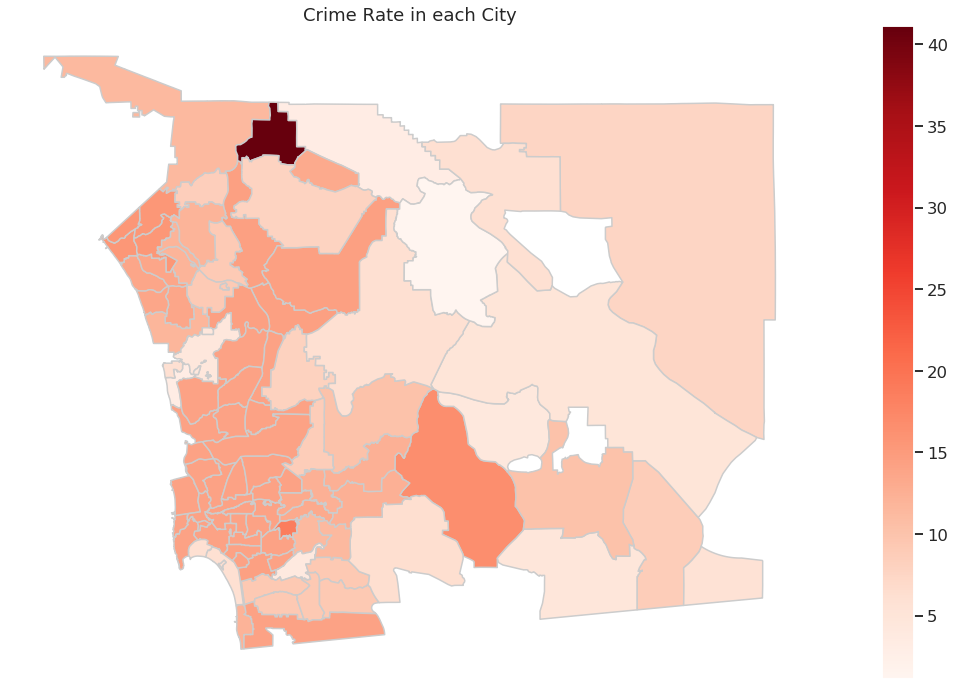

In [19]:
fig,ax=plt.subplots(nrows=1, ncols=1, figsize = (25,12))
map_city = gpd.GeoDataFrame(map_city)
map_city.plot(ax=ax, column='crimeRate', cmap='Reds',legend = True, edgecolor='0.8')
plt.title("Crime Rate in each City")
ax.axis('off')
plt.show()

# 2.2: Linear Regression Analysis

Here we create a bar plot to give a better visual the relationship between population vs. numbOfCrimes from the num_crimes_exceptSanDiego dataframe. 

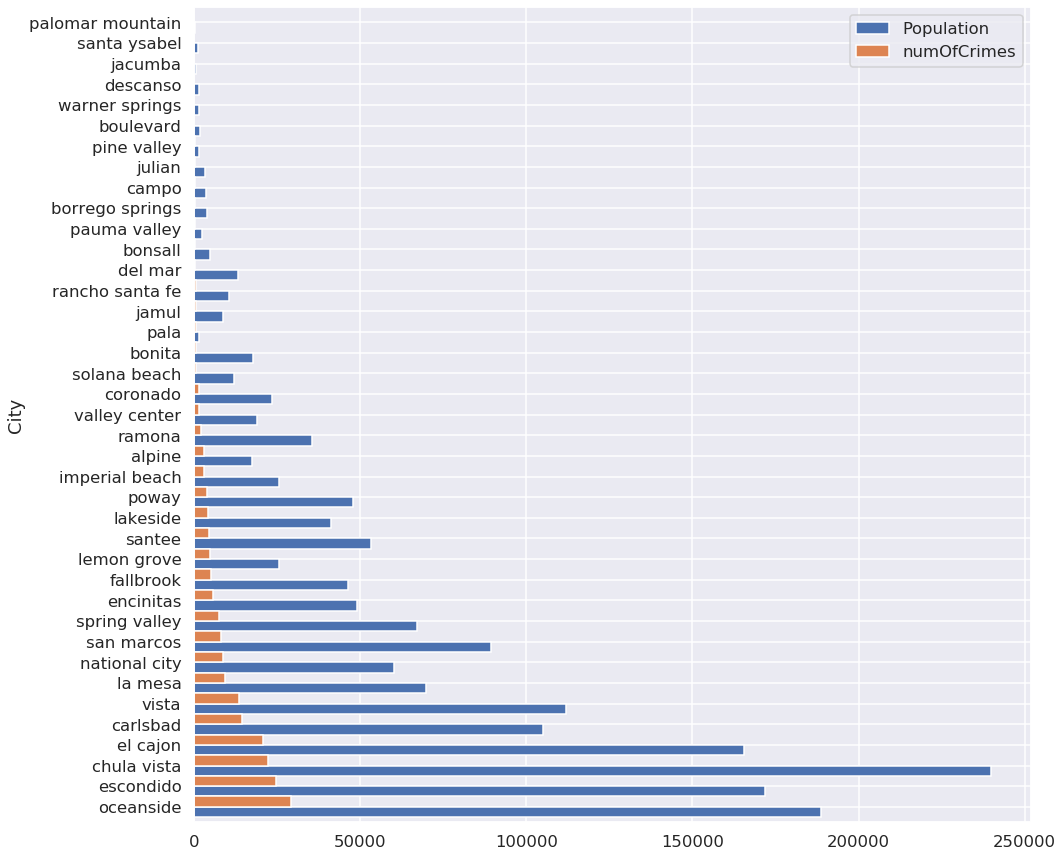

In [20]:
#barplot
num_crimes_exceptSanDiego.sort_values(by=['Population'])
num_crimes_exceptSanDiego.plot.barh(x = 'City', y = ['Population','numOfCrimes'], width = 1 , figsize=(15,15))

Our conclusion here is that the overall trend is larger the population, the larger the number the crimes are. Although the larger the population the more schools there will be, there will still be more people resulting in more crimes. We wanted to verify this and created a second plot using num_crimes_exceptSanDiego to draw the relationship between the numOfSchools and population.

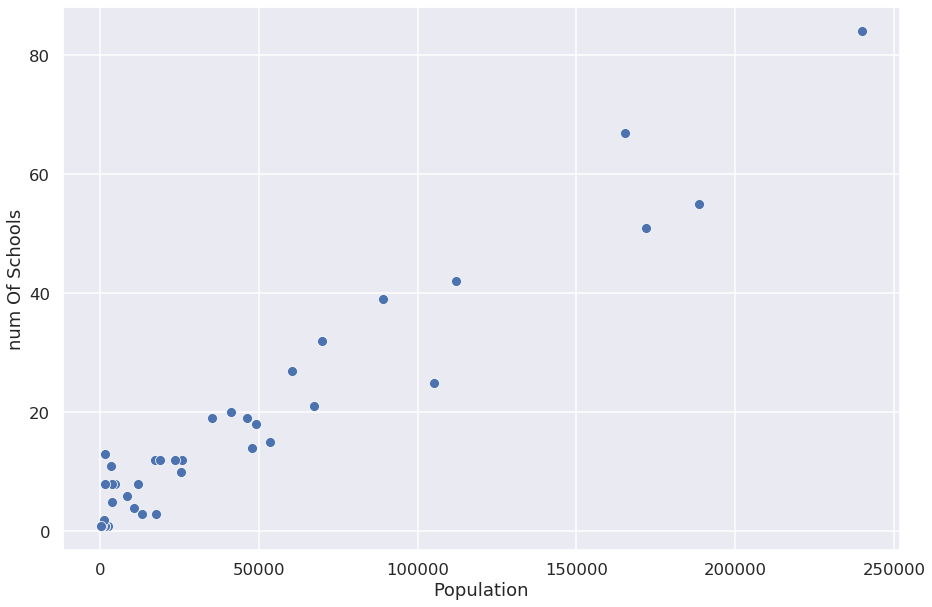

In [21]:
#sctterplot
#change plot size
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
#plot scatterplot using crimes_schools as data
sns.scatterplot(x ='Population', y ='numOfSchools', data = num_crimes_exceptSanDiego, s = 100, ax = ax)
#change x label as num of school
plt.xlabel('Population')
#change y label as num of school
plt.ylabel('num Of Schools');

Our conclusion is that the larger population the larger the number of schools. This verifies our intial thought, then for the last part we want to see the relationship between numOfSchools vs. numOfCrimes.

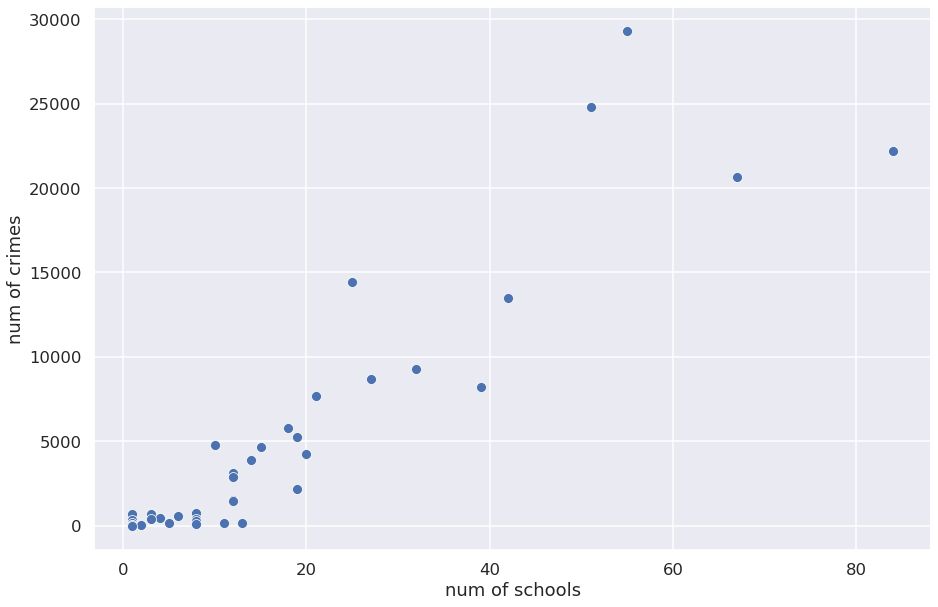

In [22]:
#sctterplot
#change plot size
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
#plot scatterplot using crimes_schools as data
sns.scatterplot(x ='numOfSchools', y ='numOfCrimes', data = num_crimes_exceptSanDiego, s = 100, ax = ax)
#change x label as num of school
plt.xlabel('num of schools')
#change y label as num of school
plt.ylabel('num of crimes');

   We find that in the plot of `num of schools vs. num of crimes`, the larger the number of schools, the larger the number of crimes. It is strange because we assume that the larger the number of schools, the smaller the number of crimes. But since the larger the number of schools, the larger the population, and according to the first plot `population vs. num of crimes`, we know that number of crimes is proportionate to population, so it can explain that the larger the number of schools, the larger the population, the larger the number of crimes.
   After realizing this strange phenomenon, we need to draw another plot `school_per_person vs. crime rate`, which can explore the correct correlation between education and crime rate.

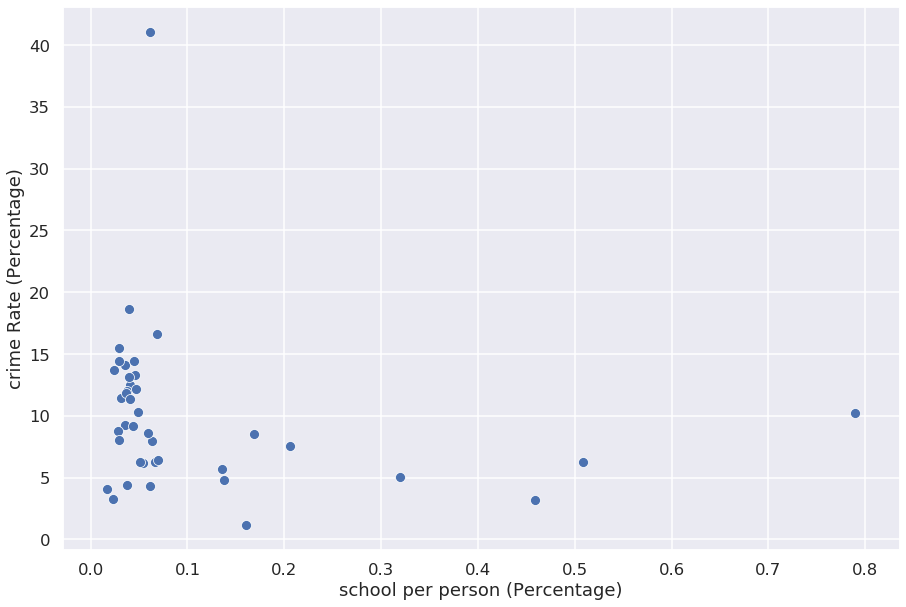

In [23]:
#scatterplot
#change plot size
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
#plot scatterplot using crimes_schools as data
sns.scatterplot(x ='school_per_person', y ='crimeRate', data = num_crimes, s = 100, ax = ax)
#change x label as num of school
plt.xlabel('school per person (Percentage)')
#change y label as num of school
plt.ylabel('crime Rate (Percentage)');

As expected, we see that the once we factor in the school per person ratio that the lower quality of education the number of crimes increased. This will be better visualized below.

In [24]:
outcome_1, predictors_1 = patsy.dmatrices('crimeRate~school_per_person', num_crimes)
print(sm.OLS(outcome_1, predictors_1).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              crimeRate   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.625
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.210
Time:                        15:49:58   Log-Likelihood:                -130.42
No. Observations:                  40   AIC:                             264.8
Df Residuals:                      38   BIC:                             268.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.9490      1.24

We see from the OLS result above that if the school_per_person were 0, the crime rate would be 10.9490% meaning for every 1 unit increase in school_per_person, you expect to see an 8.4742 unit decrease in crime rate. Although there is a relationship between schools_per_person and crime rate, we fail to reject the null since the p-value is greater than 0.01.

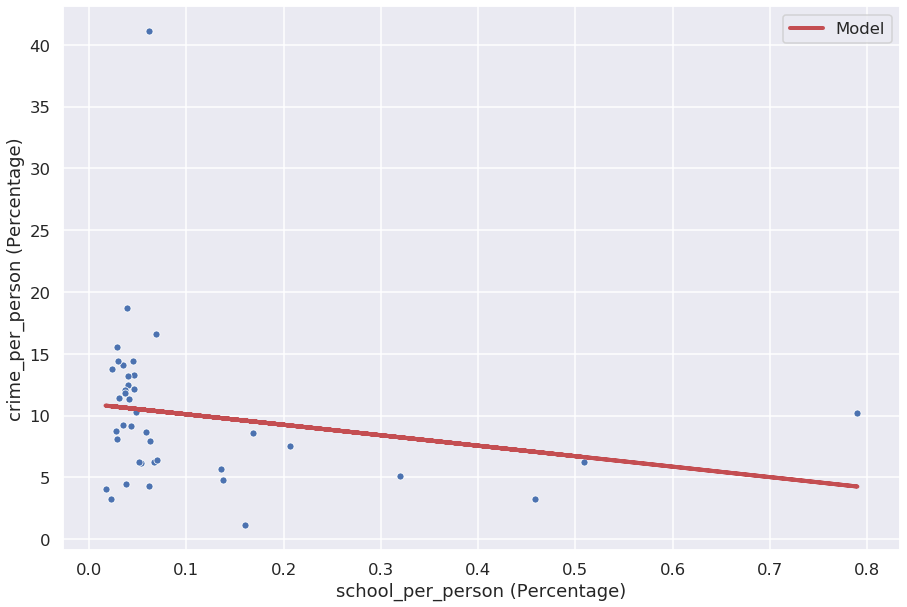

In [25]:
#change the plot size
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(x ='school_per_person', y ='crimeRate', data = num_crimes, s = 50, ax = ax)
plt.xlabel('school_per_person (Percentage)')
plt.ylabel('crime_per_person (Percentage)')

# Generate and plot the model fit line
num_crimes.sort_values(by=['school_per_person'])
xs = num_crimes['school_per_person'].to_numpy()
ys = -8.4742 * xs + 10.9490
plt.plot(xs, ys, 'r', linewidth=4, label='Model')

plt.legend();

Using the OLS results from above we're able to draw a line of best fit, which reiterates our conclusion that the lower quality of education the number of crimes increased but since we fail to reject the null we cannot conclude that better quality will result in less crimes committed.

# Ethics & Privacy

DATA PERMISSION AND CONCERNS: 

All of our data came from sites that were publically available. We used data that was publically published by the U.S. census, public school California government website. Our main concerns were determining what was considered "good education". 

Potential biases to note: 
- We did not sort the types of different crimes, so it didn't matter how severe they were from DUI to open container in public area. 


- We considered "lower education quality" to be less schools per person. Meaning that if there was a larger population with less schools in the area then more people were crammed into the school. There are many other factors that we didn't use for educational quality.

# Conclusion & Discussion

Intiially from the datasets we found we felt that higher education quality will result in lower crime rates. The dataset that we found contained the different types of crime committed in different areas. What we wanted was the crime rates so we cleaned our data up by creating a table of the total number of crimes committed (from the last 180 days) in each city which we ranked from most crimes committed to least. Similarly we cleaned our public school data up by removing those who were not in the San Diego county and sorting how many schools in each city. From this we noticed that San Diego City itself was an outlier since it had an overwhelmingly large population, large crimerate, and large number of schools. This skewed our analysis too much by overshadowing other areas of the San Diego county. We corrected this by removing San Diego city from our analysis.  

Initially we attempted to create a direct comparison using the two data but found that certain cities had larger populations which resulted in more schools and more crime rate which skewed our data. To solve this we created a new table with by calculating the crime rate = crime / population * 100 and schools per person = number of schools / population * 100 of each city. This standarized our data and allowed us to continue our analysis. We continued our analysis and found a correlation that supported our hypothesis by plotting the graphs of crime rates vs schools per person. Although there was a correlation upon further analysis of the OLS Regression results it seems that there are a lot of other cofounding variables that will cause a high crime rate. From this we see that there isn't a strong enough correlation from the datasets that we used. At first glance it appeared to have a strong correlation where the larger the schools_per_person, the lower the crime rates but upon further analysis we see that the p-value was greater than 0.01 and thus failed to reject the null.

We believe that our dataset also caused limitations in our analysis. We couldn't find publically available data of each city's average household income in San Diego County. We predict that this data would have greatly impacted our analysis for educational quality since higher income neighborhoods would most likely have better quality schools. Since we only used the number of public high school per person to determine the education quality we believe that we could have further improved what "education quality" by factoring in high school rankings, take into account private schools, charter schools, and higher education as in universities, colleges, and trade schools.  

We also believe that there are many other variables that may affect crime rates include economic conditions (average household income, job availabliity, poverty level), cultural and religious factors, degree of urbanization, the local justice system (police department, emphases of law enforcement, how these enforcements are administered), youth concentration in the area, family conditions (divorce, single parents), means of transportation, and climate.

# Team Contributions

- Xuan Ding: Largely contributed in taking leadership position by organizing the group, created meetings, and contributing ideas. Also conributed by cleaning data, organizing data and plotting data. 
- Xiuwen Ji: Largely contributed to the group by thinking up ideas, finding datasets, organizing and cleaning the data, programming different analysis, and data visualization. 
- Ruisen Huang: Largely contributed by doing most of the data plotting, statistical tests, creating the linear regression and plotting relationships between variables, and data visualization analysis. 
- Joanna Ma: Largely contributed by finding datasets, thinking up ideas, writing up the overview, writing the data analysis, ethnics and privacy, and conclusion.  
- Ivan Flores: Contributed by thinking up ideas, writing the background and prior work, searching for datasets